In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import torch
import torchvision
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection import ssd

First lets import ssd model with vgg as backbone and test it.

In [2]:
model = torchvision.models.detection.ssd300_vgg16(pretrained = True)

c:\Users\opala\miniconda3\envs\nn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\opala\miniconda3\envs\nn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

Simple transformer:

In [4]:
transform = T.Compose([
    #transforms.Resize((300, 300)),
    T.ToTensor(),
])

Lets read one of the images and get model prediction on it:

In [5]:
ig = Image.open('Annotated_images/obj_train_data/helmet_jacket_07299.jpg')
#ig = Image.open('CVAT/IMAGES/helmet_jacket_07299.jpg')
#ig = Image.open('C:/Users/opala/OneDrive/Pulpit/EPAM_mentoring/Module3/Annotated_images/obj_train_data/helmet_jacket_07299.jpg')
img = transform(ig)

with torch.no_grad():
    pred = model([img])

We select detections with at least 0.5 score - model evaluates the probability of detected object being in the bounding box as higher than 50%.

In [6]:
bboxes, scores, labels = pred[0]['boxes'], pred[0]['scores'], pred[0]['labels']

num = torch.argwhere(scores > 0.5).shape[0]

Because the model was pretrained on COCO dataset we need to import the names of classes present in it:

In [7]:
font = cv2.FONT_HERSHEY_SIMPLEX

coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" , 
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" , 
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" , 
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" , 
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]

Lets check how accurate is the prediction:

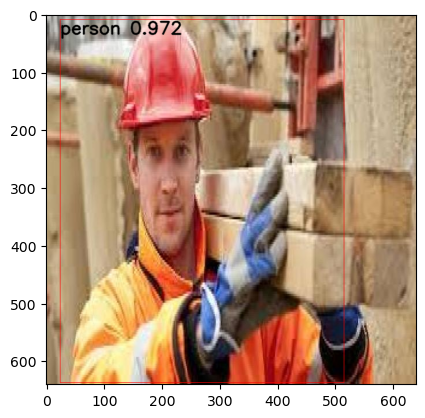

In [8]:
igg = cv2.imread('Annotated_images/obj_train_data/helmet_jacket_07299.jpg')
igg = cv2.cvtColor(igg, cv2.COLOR_BGR2RGB)

for i in range(num):
    x1,y1,x2,y2 = bboxes[i].numpy().astype('int')
    igg = cv2.rectangle(igg, (x1, y1), (x2,y2), (255,0,0), 1)
    class_name = coco_names[labels.numpy()[i] - 1]
    score = str(scores[i].item())[:5] #str(scores[labels.numpy()[i]].item())[:5]
    igg = cv2.putText(igg, class_name + ' ' + score, (x1, y1 + 25), font, 1, (0,0,0), 2, cv2.LINE_AA)

plt.imshow(igg)
plt.show()

Pretty good. It managed to detect a person with high certainty. It was the only object from COCO present in the image.

Now lets create a list of path to our training images and their annotations.

In [9]:
images_path = 'Annotated_images\obj_train_data'
os.chdir(images_path)

img_paths = []
annotations_paths = []

for current_dir, dirs, files in os.walk('.'):
  for f in files:
    if f.endswith('.jpg'):
      file_loc = images_path + '/' + f
      img_paths.append(file_loc + '\n')
    elif f.endswith('.txt'):
      file_loc = images_path + '/' + f
      annotations_paths.append(file_loc + '\n')

Train-test splitting:

In [10]:
train_paths = img_paths[:int(0.8 * len(img_paths))]
val_paths   = img_paths[int(0.8 * len(img_paths)):int(0.9 * len(img_paths))]
test_paths  = img_paths[int(0.9 * len(img_paths)):]

train_paths_annotations = annotations_paths[:int(0.8 * len(annotations_paths))]
val_paths_annotations = annotations_paths[int(0.8 * len(annotations_paths)):int(0.9 * len(annotations_paths))]
test_paths_annotations  = annotations_paths[int(0.9 * len(annotations_paths)):]

Now we can save all the paths in txt files to acces them easily later.

In [11]:
train_test_loc = 'C:/Users/opala/OneDrive/Pulpit/EPAM_mentoring/Module3/Annotated_images'
os.chdir(train_test_loc)

with open('train.txt', 'w') as train:
  for i in train_paths:
    train.write(i)

with open('train_ann.txt', 'w') as train:
  for i in train_paths_annotations:
    train.write(i)

with open('val.txt', 'w') as val:
  for i in val_paths:
    val.write(i)

with open('val_ann.txt', 'w') as val:
  for i in val_paths_annotations:
    val.write(i)

with open('test.txt', 'w') as test:
  for i in test_paths:
    test.write(i)

with open('test_ann.txt', 'w') as test:
  for i in test_paths_annotations:
    test.write(i)

Now we are going to create a dataset class for reading the data from files.

In [12]:
class SSD_Dataset(Dataset):
    def __init__(self, image_paths, annotation_paths, transform=None):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        os.chdir('C:/Users/opala/OneDrive/Pulpit/EPAM_mentoring/Module3')

        image = Image.open(self.image_paths[idx][:-1]).convert("RGB")

        with open(self.annotation_paths[idx][:-1], 'r') as f:
            annotations = f.readlines()

        # Convert annotations to target format
        boxes = []
        labels = []
        for annotation in annotations:
            # Parse annotation (class, x_center, y_center, width, height)
            annotation = annotation.strip().split(' ')
            class_label = int(annotation[0]) + 1
            x_center, y_center, width, height = map(float, annotation[1:])
            
            # Convert relative coordinates to absolute coordinates
            image_width, image_height = image.size
            x_center_abs = x_center * image_width
            y_center_abs = y_center * image_height
            width_abs = width * image_width
            height_abs = height * image_height
            
            # Convert from (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
            x_min = x_center_abs - width_abs / 2
            y_min = y_center_abs - height_abs / 2
            x_max = x_center_abs + width_abs / 2
            y_max = y_center_abs + height_abs / 2
            
            # Append box coordinates and class label
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_label)

        # Convert boxes and labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Define image_id, area, and iscrowd
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Create target dictionary
        target = {
            "boxes": boxes,#[0],#tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        
        if self.transform:
            image = self.transform(image)

        # Return image and annotations
        return image, target

Here we are using our  SSD_Dataset class to create data loader that will be used during training and inference.

In [13]:
loc = 'C:/Users/opala/OneDrive/Pulpit/EPAM_mentoring/Module3'
os.chdir(loc)

train_dataset = SSD_Dataset(train_paths, train_paths_annotations, transform=transform)
val_dataset = SSD_Dataset(val_paths, val_paths_annotations, transform=transform)
test_dataset = SSD_Dataset(test_paths, test_paths_annotations, transform=transform)

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Stack images into a single tensor
    images = torch.stack(images, dim=0)

    # Create lists to hold targets
    batch_boxes = []
    batch_labels = []
    batch_image_ids = []
    batch_areas = []
    batch_iscrowds = []

    # Iterate through each target dictionary in the batch
    for target in targets:
        # Append each target field to the corresponding list
        batch_boxes.append(target["boxes"])
        print(target["boxes"].shape)
        batch_labels.append(target["labels"])
        batch_image_ids.append(target["image_id"])
        batch_areas.append(target["area"])
        batch_iscrowds.append(target["iscrowd"])

    # Stack boxes and labels into tensors
    print('chej', len(batch_boxes))
    batch_boxes = torch.stack(batch_boxes, dim=0)
    batch_labels = torch.stack(batch_labels, dim=0)
    batch_image_ids = torch.tensor(batch_image_ids)
    batch_areas = torch.stack(batch_areas, dim=0)
    batch_iscrowds = torch.stack(batch_iscrowds, dim=0)
 

    # Return images and targets as a tuple
    return images, {
        "boxes": batch_boxes,
        "labels": batch_labels,
        "image_id": batch_image_ids,
        "area": batch_areas,
        "iscrowd": batch_iscrowds
    }

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)#torch.utils.data._utils.collate.collate)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

For our dataset we are going to use pretrained Faster RCNN with ResNet50 as backbone. We just need to make it compatible with ou number of classes (2 + 1 for background).

In [14]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 3

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Time for training. As an optimizer we are using SGD.

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

loss_history = []
val_loss_history = []

patience = 2
best_val_loss = np.inf
counter = 0

for epoch in range(20):
    model.train()
    batches_loss = []
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        batches_loss.append(losses.detach()/len(images))
        optimizer.step()
    
    avg_loss = sum(batches_loss) / len(batches_loss)
    loss_history.append(avg_loss)

    #Validation
    #model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            batches_loss.append(losses.detach()/len(images))

    val_loss = sum(batches_loss) / len(batches_loss)
    val_loss_history.append(val_loss)

    print(f'Epoch: {epoch}, Loss: {avg_loss}, Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Patience exceeded. Early stopping.")
            break


C:\Users\opala\AppData\Local\Temp\ipykernel_7324\3930771590.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


C:\Users\opala\AppData\Local\Temp\ipykernel_7324\3930771590.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Epoch: 0, Loss: 0.21652063727378845, Validation Loss: 0.24489369988441467
Epoch: 1, Loss: 0.19968768954277039, Validation Loss: 0.2322007119655609
Epoch: 2, Loss: 0.19950906932353973, Validation Loss: 0.22856397926807404
Epoch: 3, Loss: 0.17542418837547302, Validation Loss: 0.2086351364850998
Epoch: 4, Loss: 0.14660164713859558, Validation Loss: 0.18110588192939758
Epoch: 5, Loss: 0.14352478086948395, Validation Loss: 0.1831052452325821
Epoch: 6, Loss: 0.14596769213676453, Validation Loss: 0.18389420211315155
Patience exceeded. Early stopping.


Looks good. Loss was decreased significantly during training.

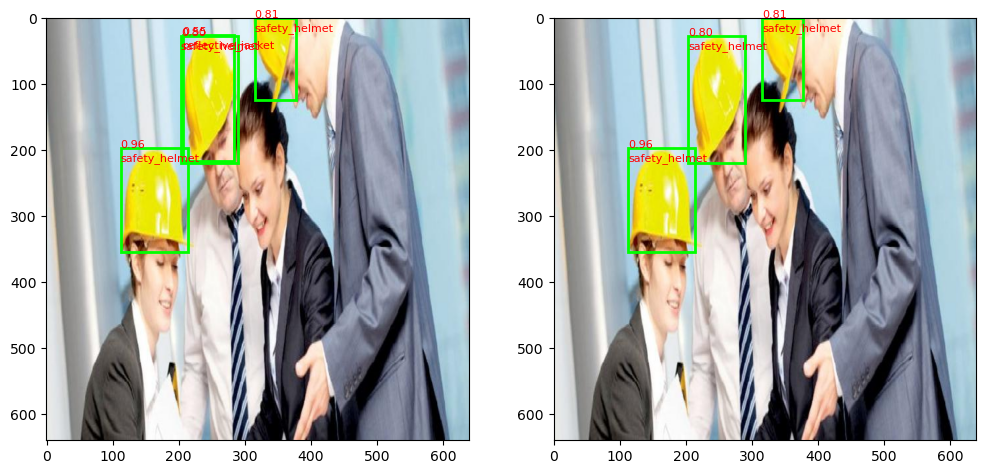

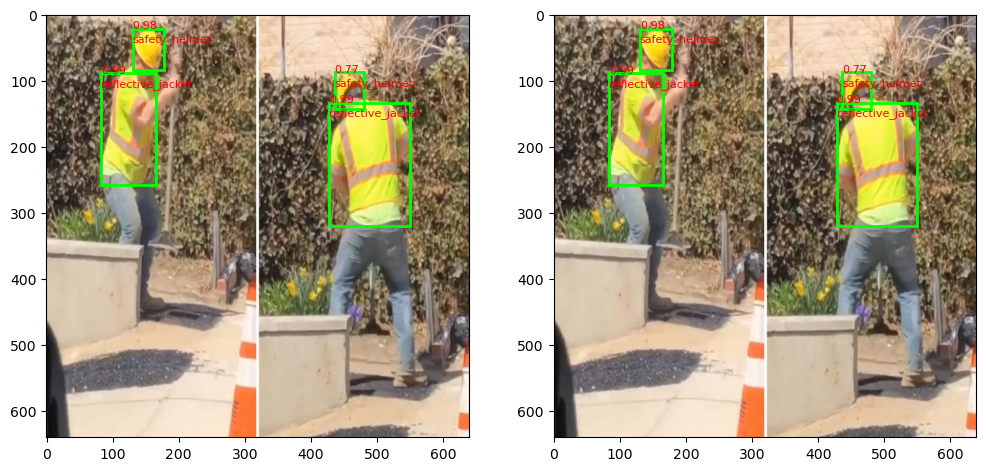

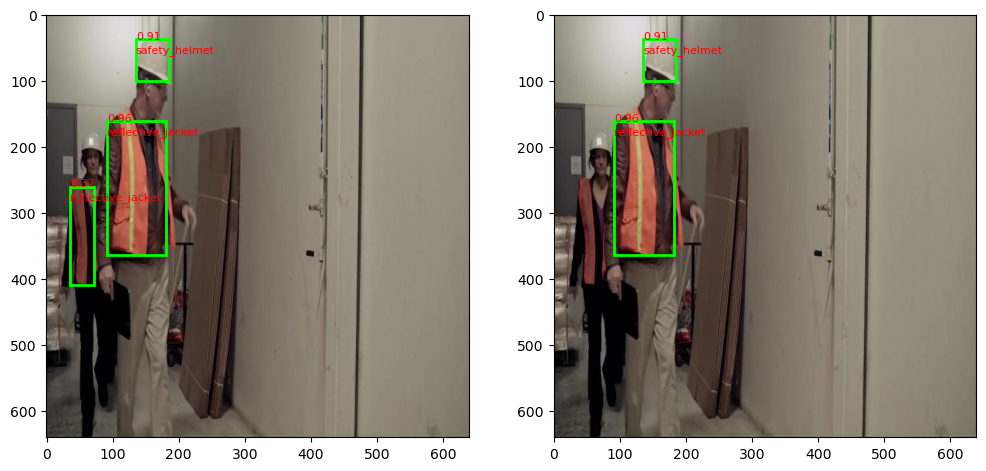

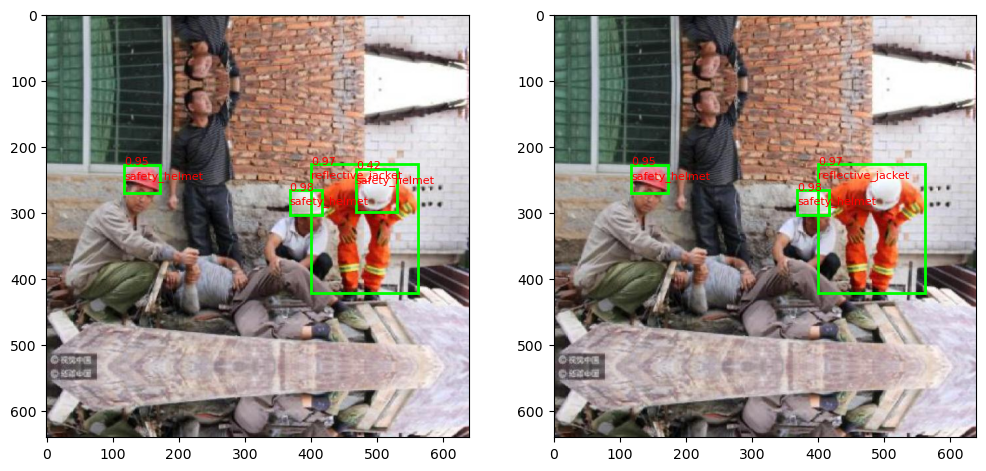

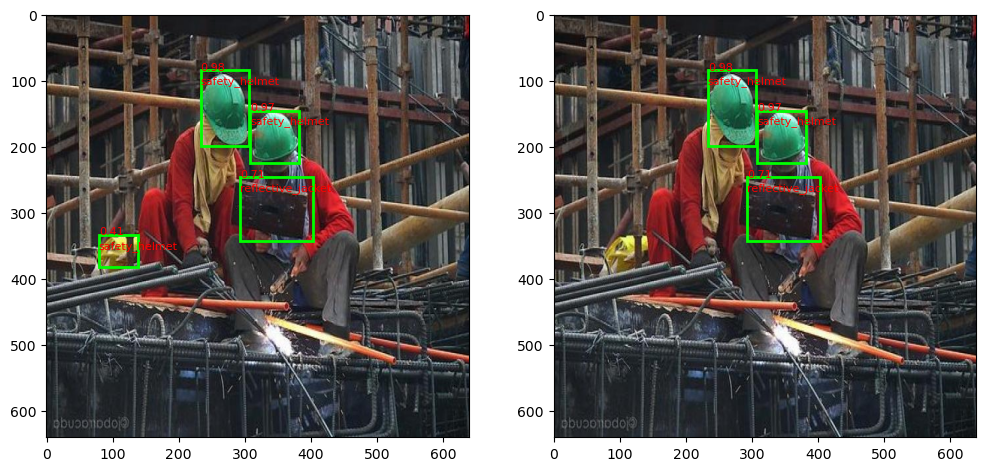

In [32]:
import matplotlib.patches as patches

model.eval()
class_names = {1: 'reflective_jacket',
               2: 'safety_helmet'}

for images, targets in test_dataloader:

    images = list(image.to(device) for image in images)
    
    with torch.no_grad():
        pred = model(images)

    for image, prediction in zip(images, pred):
        image = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()  # Convert image to numpy array
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = prediction['boxes'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()

        # Filter predictions with scores >= 0.2
        keep_indices1 = np.where(scores >= 0.2)[0]
        keep_indices2 = np.where(scores >= 0.6)[0]

        boxes1 = boxes[keep_indices1]
        scores1 = scores[keep_indices1]
        labels1 = labels[keep_indices1]
        boxes2 = boxes[keep_indices2]
        scores2 = scores[keep_indices2]
        labels2 = labels[keep_indices2]

        fig, ax = plt.subplots(1,2,figsize=(12,6))

        # Plot bounding boxes
        for box, score, label in zip(boxes1, scores1, labels1):
            x1, y1, x2, y2 = box.astype(int)
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=(0, 1, 0), facecolor='none')
            ax[0].add_patch(rect)
            ax[0].text(x1, y1, f"{score:.2f}", fontsize=8, color=(1, 0, 0))
            ax[0].text(x1, y1 + 20, class_names[label], fontsize=8, color=(1, 0, 0))
            ax[0].imshow(image)

        for box, score, label in zip(boxes2, scores2, labels2):
            x1, y1, x2, y2 = box.astype(int)
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=(0, 1, 0), facecolor='none')
            ax[1].add_patch(rect)
            ax[1].text(x1, y1, f"{score:.2f}", fontsize=8, color=(1, 0, 0))
            ax[1].text(x1, y1 + 20, class_names[label], fontsize=8, color=(1, 0, 0))
            ax[1].imshow(image)

        # Show image
        #plt.figure(figsize=(6, 6))
        #plt.imshow(image)
        plt.show()

We can see on the test set that overall the model is doing pretty well. If we set the threshold high (0.5-0.6 score) then it for example misses the lady in the 3rd image. If we set it lower it is able to find her jacket but also starts to mistakenly detect some objects (like helmet in the first image for jacket).